In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from tensorflow.keras.layers import Conv2D,Input,add

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
train_images=glob.glob("/kaggle/input/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/*")
valid_images=glob.glob("/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/*")

# Observing 5 random images in Train Set

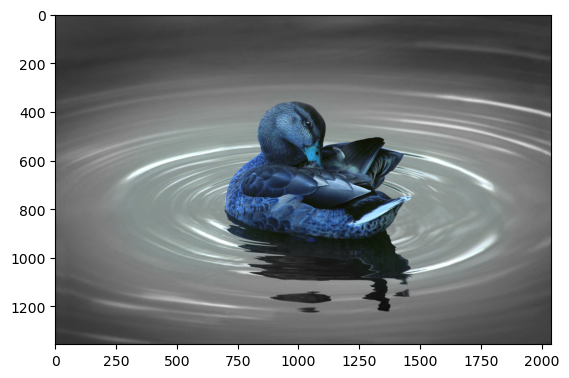

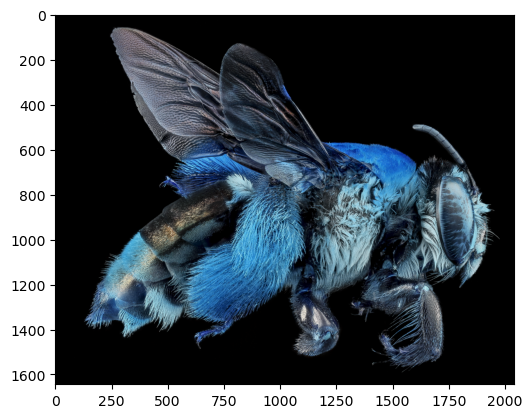

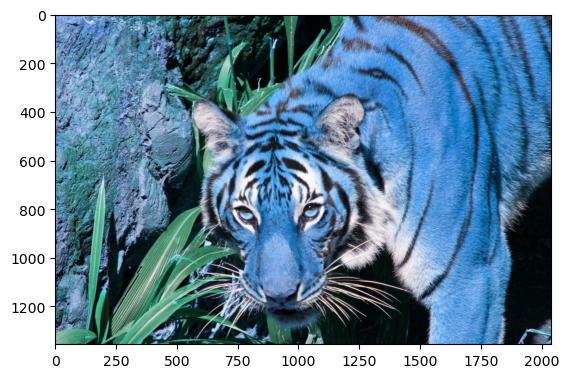

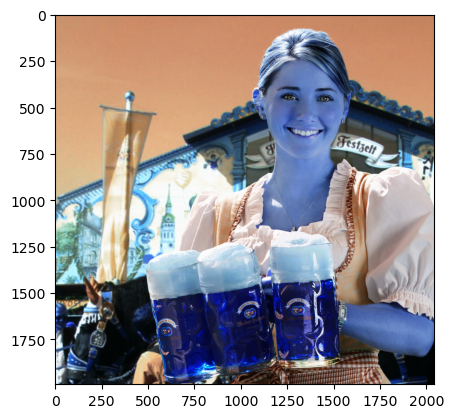

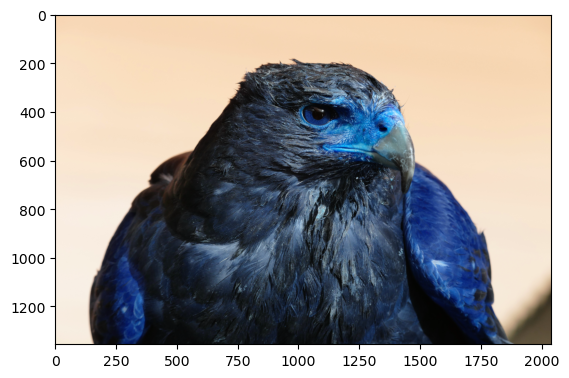

In [3]:
np.random.seed(41)
rand_ix=np.random.randint(0,799,size=5,dtype=int)
for ix in rand_ix:
    img=cv2.imread(train_images[ix])
    plt.imshow(img)
    plt.show()

One thing that can be concluded from here is that not all images have the same aspect ratio. So, we will build a model capable of taking inputs of varying aspect ratios.

# Converting to Jpeg images for training

In [4]:
for dir_name in ["train_jpeg","val_jpeg"]:
    directory="/kaggle/working/"+dir_name+"/"
    if not(os.path.exists(directory)):
        os.makedirs(directory)

In [5]:
train_dir="/kaggle/working/train_jpeg/"
val_dir="/kaggle/working/val_jpeg/"
if(glob.glob(train_dir+'/*')==[] or glob.glob(val_dir+'/*')==[]):
    for png_dir,jpeg_dir in zip([train_images,valid_images],[train_dir,val_dir]):
        for image in tqdm(png_dir):
            img_array=cv2.imread(image)
            cv2.imwrite(jpeg_dir+os.path.basename(image).split(".")[0]+".jpeg",img_array)

100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


# Preprocesing and Building the Datasets

In [6]:
class Generator(keras.utils.Sequence):
    def __init__(self,x:list,y:list):
        self.x=x
        self.y=y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self,index):
        x=self.x[index]
        y=self.y[index]
        return x,y
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            if i==self.__len__()-1:
                self.on_epoch_end()

In [7]:
def preprocessing(path,ratio=4,resize_height=256,resize_width=256):
    hr=tf.keras.utils.load_img(path)
    hr=tf.keras.utils.img_to_array(hr)
    hr=tf.image.resize(hr,[resize_height,resize_width],'bicubic',antialias=True)
    height,width,channels=hr.shape
    lr=tf.image.resize(hr,[height//ratio,width//ratio],'bicubic',antialias=True)
    lr=lr/255.0
    hr=hr/255.0
    return lr,hr

In [8]:
train_paths=glob.glob("/kaggle/working/train_jpeg/*")
val_paths=glob.glob("/kaggle/working/val_jpeg/*")

In [9]:
test_ix=np.random.randint(0,99,size=5,dtype=int)
test_paths=[]
for ix in test_ix:
    test_paths+=[val_paths[ix]]
    del val_paths[ix]

In [10]:
def lr_and_hr(img_paths,lr_tensor_path='./lr_tensor.npy',hr_tensor_path='./hr_tensor.npy'):
    if not(os.path.exists(lr_tensor_path)) or not(os.path.exists(hr_tensor_path)):
        img_lr = []
        img_hr = []
        for i in tqdm(range(len(img_paths))):
            lr,hr=preprocessing(img_paths[i])
            img_lr.append(lr)
            img_hr.append(hr)
        lr_tensor=tf.convert_to_tensor(img_lr).numpy()
        hr_tensor=tf.convert_to_tensor(img_hr).numpy()
        np.save(lr_tensor_path,lr_tensor)
        np.save(hr_tensor_path,hr_tensor)
        img_lr=lr_tensor
        img_hr=hr_tensor
    else:
        img_lr=np.load(lr_tensor_path)
        img_hr=np.load(hr_tensor_path)
    return img_lr,img_hr

In [11]:
generators=[]
paths=[train_paths,val_paths,test_paths]
tensor_paths=[['./lr_tensor.npy','./hr_tensor.npy'],['./lr_tensor_val.npy','./hr_tensor_val.npy'],
              ['./lr_tensor_test.npy','./hr_tensor_test.npy']]
i=0
for path_list in paths:
    x,y=lr_and_hr(path_list,lr_tensor_path=tensor_paths[i][0],hr_tensor_path=tensor_paths[i][1])
    generators+=[Generator(x,y)]
    i+=1
train_generator=generators[0]
val_generator=generators[1]
test_generator=generators[2]

100%|██████████| 5/5 [00:00<00:00,  6.90it/s]


Text(0.5, 1.0, 'High-res image(Right)')

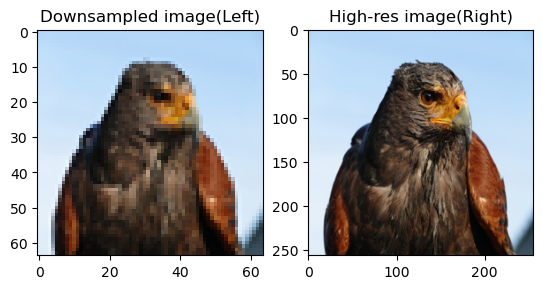

In [12]:
x,y=train_generator[0]
plt.subplot(121)
plt.imshow(x)
plt.title("Downsampled image(Left)")
plt.subplot(122)
plt.imshow(y)
plt.title("High-res image(Right)")

In [13]:
def dataset_preparation(generator,output_shapes=([None, None, 3],[None, None, 3]),
                        output_types=(x.dtype,y.dtype),shuffle=False,batch_size=16,prefetch_size=10):
    dataset=tf.data.Dataset.from_generator(generator,output_shapes=output_shapes,output_types=output_types).batch(batch_size)
    if(shuffle==True):
        dataset=dataset.shuffle(len(generator)+1,reshuffle_each_iteration=True)
    dataset=dataset.prefetch(prefetch_size)
    dataset=dataset.cache()
    return dataset

In [14]:
train_ds=dataset_preparation(train_generator,shuffle=True)
val_ds=dataset_preparation(val_generator,shuffle=True)
test_ds=dataset_preparation(test_generator)

# Model Building

In [15]:
strategy=tf.distribute.MirroredStrategy()

In [16]:
with strategy.scope():
    def FCN_model(upscale=4):
        inputs=Input(shape=(None,None,3))
        x=Conv2D(64,5,activation="relu",padding="same")(inputs)
        x=Conv2D(64,3,activation="relu",padding="same")(x)
        x=Conv2D(32,3,activation="relu",padding="same")(x)
        x=Conv2D(3*(upscale**2),3,activation="relu",padding="same")(x)
        outputs=tf.nn.depth_to_space(x,upscale)
        return tf.keras.Model(inputs,outputs)

In [17]:
with strategy.scope():
    model=FCN_model()
    model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    4864      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 48)    13872     
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 3)    0         
 ambda)                                                          
                                                             

# Custom Losses and Metrics

In [18]:
with strategy.scope():
    @tf.function
    def MeanGradientError(targets,outputs):
        filter_x=tf.tile(tf.expand_dims(tf.constant([[-1,-2,-2],[0,0,0],[1,2,1]],
                                                      dtype=outputs.dtype),axis=-1),[1,1,outputs.shape[-1]])
        filter_x=tf.tile(tf.expand_dims(filter_x,axis=-1),[1,1,1,outputs.shape[-1]])
        filter_y=tf.tile(tf.expand_dims(tf.constant([[-1,0,1],[-2,0,2],[-1,0,1]],dtype=outputs.dtype),axis=-1),
                         [1, 1,targets.shape[-1]])
        filter_y=tf.tile(tf.expand_dims(filter_y,axis=-1),[1,1,1,targets.shape[-1]])
        output_gradient_x=tf.math.square(tf.nn.conv2d(outputs,filter_x,strides=1,padding='SAME'))
        output_gradient_y=tf.math.square(tf.nn.conv2d(outputs,filter_y,strides=1,padding='SAME'))
        target_gradient_x=tf.math.square(tf.nn.conv2d(targets,filter_x,strides=1,padding='SAME'))
        target_gradient_y=tf.math.square(tf.nn.conv2d(targets,filter_y,strides=1,padding='SAME'))
        output_gradients=tf.math.add(output_gradient_x,output_gradient_y)
        target_gradients=tf.math.add(target_gradient_x,target_gradient_y)
        mge=tf.keras.metrics.mean_absolute_error(output_gradients,target_gradients)
        return mge
    
    @tf.function
    def loss_sum(y_true,y_pred):
        mae=tf.keras.metrics.mean_absolute_error(y_true,y_pred)
        mge=MeanGradientError(y_true,y_pred)
        return mae+0.1*mge

# Callbacks and Training

In [19]:
with strategy.scope():
    early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=15,min_delta=0.01,mode='min',
                                                    restore_best_weights=True)
    checkpoint=tf.keras.callbacks.ModelCheckpoint("/kaggle/working/model_2.h5",monitor="val_loss",save_best_only=True,
                                                  save_freq='epoch',mode='min')
    lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=5,verbose=1,mode="min",min_delta=0.001)
    model.compile(optimizer="Adam",loss=loss_sum,metrics=['mae',MeanGradientError])

In [20]:
with strategy.scope():
    history = model.fit(train_ds,epochs=300,verbose=True,validation_data=val_ds,callbacks=[early_stopping,checkpoint,lr])

Epoch 1/300
50/50 [==============================] - 22s 58ms/step - loss: 0.6795 - mae: 0.2151 - MeanGradientError: 4.6444 - val_loss: 0.5713 - val_mae: 0.1300 - val_MeanGradientError: 4.4132 - lr: 0.0010
Epoch 2/300
50/50 [==============================] - 2s 41ms/step - loss: 0.5218 - mae: 0.1162 - MeanGradientError: 4.0553 - val_loss: 0.5049 - val_mae: 0.0969 - val_MeanGradientError: 4.0800 - lr: 0.0010
Epoch 3/300
50/50 [==============================] - 2s 31ms/step - loss: 0.4690 - mae: 0.0865 - MeanGradientError: 3.8252 - val_loss: 0.4671 - val_mae: 0.0784 - val_MeanGradientError: 3.8864 - lr: 0.0010
Epoch 4/300
50/50 [==============================] - 1s 29ms/step - loss: 0.4416 - mae: 0.0737 - MeanGradientError: 3.6791 - val_loss: 0.4541 - val_mae: 0.0724 - val_MeanGradientError: 3.8170 - lr: 0.0010
Epoch 5/300
50/50 [==============================] - 1s 29ms/step - loss: 0.4253 - mae: 0.0694 - MeanGradientError: 3.5595 - val_loss: 0.4613 - val_mae: 0.0815 - val_MeanGradientE

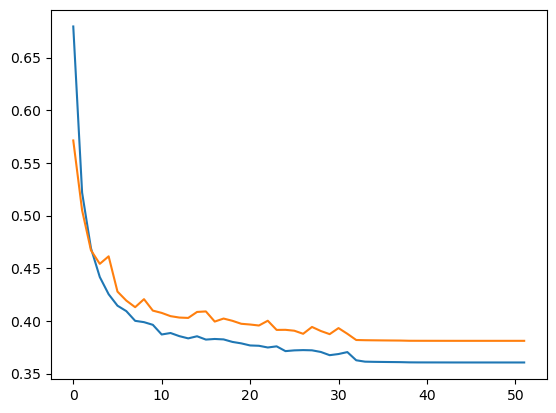

In [21]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')

# Predictions

In [22]:
model=tf.keras.models.load_model('/kaggle/working/model_2.h5',compile=False)
predictions=model.predict(test_ds)

1/1 [==============================] - 0s 364ms/step


Text(0.5, 1.0, 'High-res image')

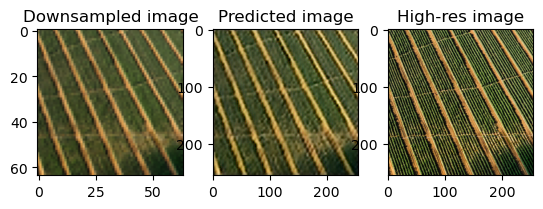

In [23]:
prediction=predictions[1]
x,y=test_generator[1]
plt.subplot(131)
plt.imshow(x)
plt.title("Downsampled image")
plt.subplot(132)
plt.imshow(prediction)
plt.title("Predicted image")
plt.subplot(133)
plt.imshow(y)
plt.title("High-res image")

# Predicting for provided test images

In [24]:
directory="/kaggle/working/predicted_output/"
if not(os.path.exists(directory)):
    os.makedirs(directory)

1/1 [==============================] - 2s 2s/step


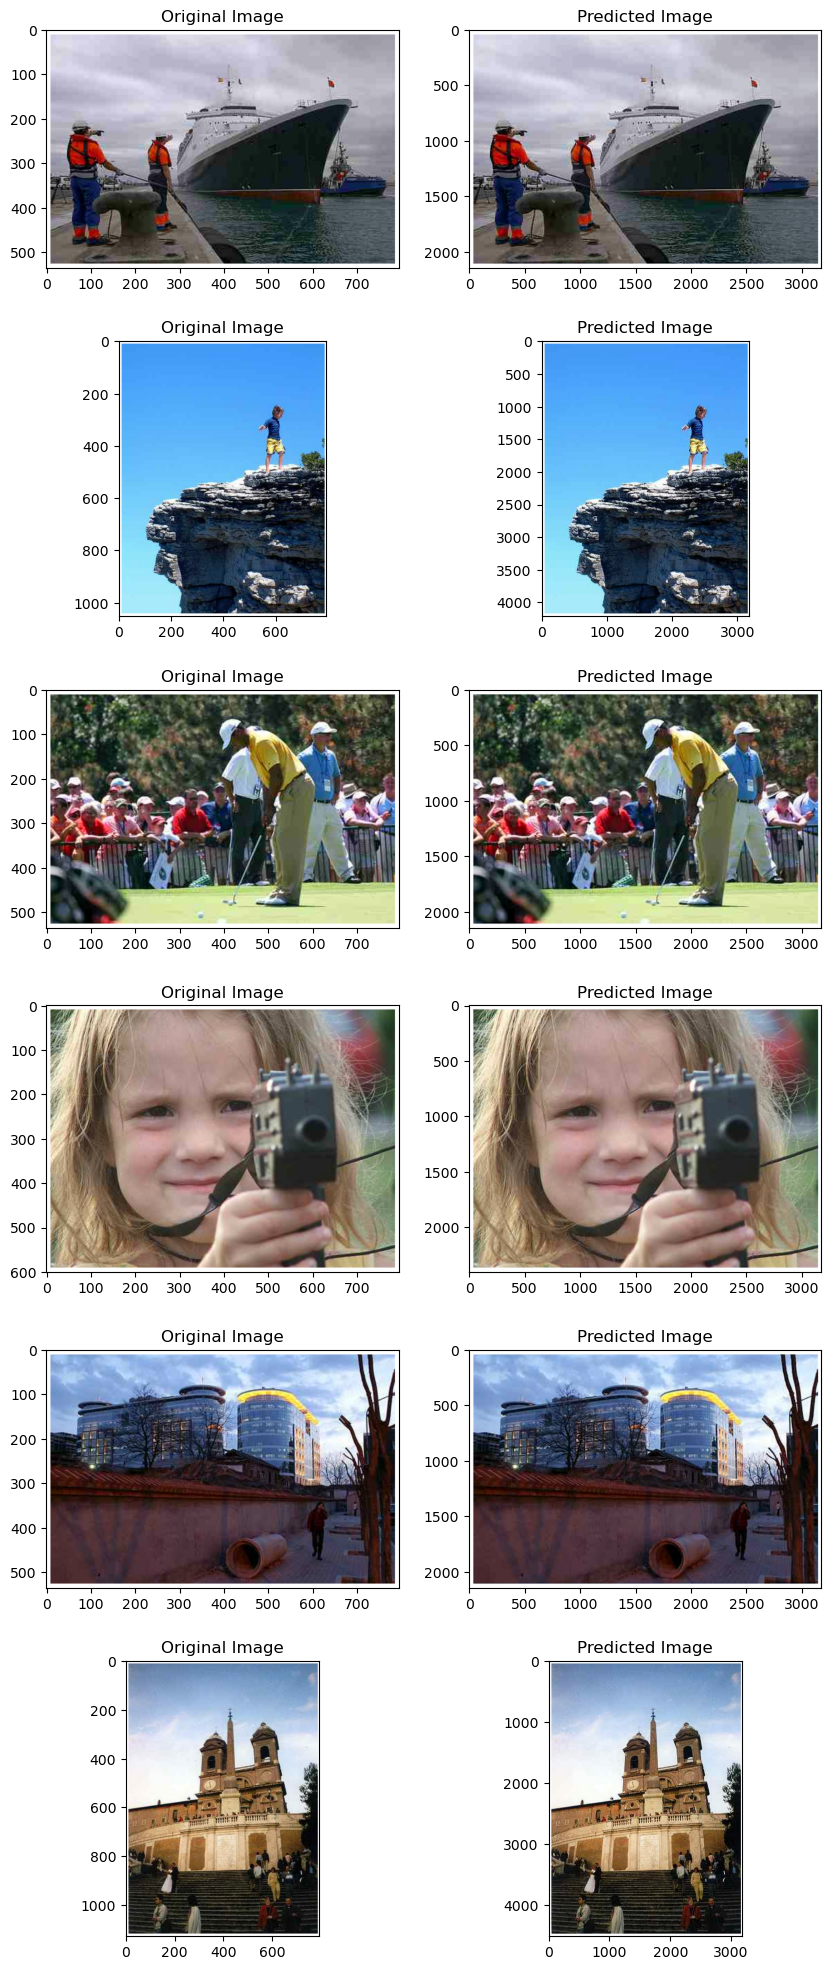

In [25]:
imgs=[]
i=1
plt.figure(figsize=(10,25))
for path in glob.glob("/kaggle/input/div2k-test-set/*"):
    plt.subplot(6,2,i)
    x=cv2.imread(path)
    plx=cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    plt.imshow(plx)
    x=tf.keras.utils.load_img(path)
    x=tf.keras.utils.img_to_array(x)
    x=x/255.0
    plt.title("Original Image")
    plt.subplot(6,2,i+1)
    pred=model.predict(tf.expand_dims(x,axis=0))
    plt.imshow(pred[0])
    plt.title("Predicted Image")
    pic=cv2.cvtColor(pred[0],cv2.COLOR_BGR2RGB)
    cv2.imwrite("/kaggle/working/predicted_output/"+path[:-4].split("/")[-1]+".png",255*pic)
    i+=2

In [26]:
!zip -r -j /kaggle/working/predicted_output.zip /kaggle/working/predicted_output

  adding: test_image_1.png (deflated 5%)
  adding: test_image_6.png (deflated 11%)
  adding: test_image_5.png (deflated 5%)
  adding: test_image_4.png (deflated 35%)
  adding: test_image_3.png (deflated 4%)
  adding: test_image_2.png (deflated 16%)
